In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

from sklearn.model_selection import train_test_split


In [121]:

def parse_data(file_path):
    sequences = []
    labels = []
 
    with open(file_path, "r") as file:
        for line in file:
            if line == "end\n" or line == "<end>":
                sequences.append("end")
                labels.append("end")
                #print("End of sequence")
            elif len(line) == 4:
                sequences.append(line[0]) # Amino acid
                labels.append(line[2]) # e, h, _
                          
            else:
                #print("Something else")
                #print(line)
                pass
        
    
    return sequences, labels

def encode_seqeuences(sequences):
    amino_acid_mapping = {
    'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
    'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
    'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
    'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19,
    'end': 20
    }
    encoded_seqs = []
    for amino_acid in sequences:
        encoding = [0]*21
        encoding[amino_acid_mapping[amino_acid]] = 1
        encoded_seqs.append(encoding)

    return encoded_seqs

def encode_labels(labels):
    label_mapping = {
    'e': 0, 'h': 1, '_': 2, 'end': 3
    }
    #print("encoding labels")
    encoded_labels = []
    for label in labels:
        encoded_label = [0,0,0]
        if label_mapping[label] != 3:
            encoded_label[label_mapping[label]] = 1
        encoded_labels.append(encoded_label)
    return encoded_labels

    
seq,labels = parse_data("protein-secondary-structure.train.txt")
#print(seq)
eseq = encode_seqeuences(seq)
#print(labels)
elab = encode_labels(labels)


In [122]:

#Confirm that the encoding is correct
foundVal = ""
count = 0
while foundVal != "end":
    foundVal = seq[count]
    fV = eseq[count]
    #print("Character",foundVal,"is encoded as",fV)
    
    count += 1

print("End found at:",count)
count = 0
foundVal = []
while foundVal != [0]*20 + [1]: # when it finds foundVal = [0]*21, it will stop
    foundVal = eseq[count]
    count += 1   
print("End found at:",count)

End found at: 325
End found at: 325


In [123]:

def build_model(input_shape):
    learning_rate = 0.0005
    optim = Adam(learning_rate=learning_rate)
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Hidden layer with 40 units
        Dense(3, activation='softmax')  # Output layer for the three types of secondary structures
    ])
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def create_sliding_windows(encoded_seqs, window_size=13):
    # Padding to handle boundaries
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    
    # Create sliding windows
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows


In [124]:

windowed_input = create_sliding_windows(np.array(eseq))


# Assuming elab is already one-hot encoded
X_train, X_test, y_train, y_test = train_test_split(windowed_input, elab, test_size=0.2, random_state=42)
# Build the model with the correct input shape
model = build_model(X_train.shape[1])
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)


Epoch 1/100
455/455 [==============================] - 1s 2ms/step - loss: 0.9624 - accuracy: 0.5402 - val_loss: 0.9211 - val_accuracy: 0.5442
Epoch 2/100
455/455 [==============================] - 1s 2ms/step - loss: 0.8944 - accuracy: 0.5635 - val_loss: 0.8720 - val_accuracy: 0.5791
Epoch 3/100
455/455 [==============================] - 1s 2ms/step - loss: 0.8500 - accuracy: 0.6035 - val_loss: 0.8455 - val_accuracy: 0.6060
Epoch 4/100
455/455 [==============================] - 1s 2ms/step - loss: 0.8240 - accuracy: 0.6268 - val_loss: 0.8291 - val_accuracy: 0.6170
Epoch 5/100
455/455 [==============================] - 1s 1ms/step - loss: 0.8103 - accuracy: 0.6325 - val_loss: 0.8232 - val_accuracy: 0.6272
Epoch 6/100
455/455 [==============================] - 1s 1ms/step - loss: 0.8026 - accuracy: 0.6406 - val_loss: 0.8193 - val_accuracy: 0.6291
Epoch 7/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7982 - accuracy: 0.6393 - val_loss: 0.8185 - val_accuracy: 0.6283

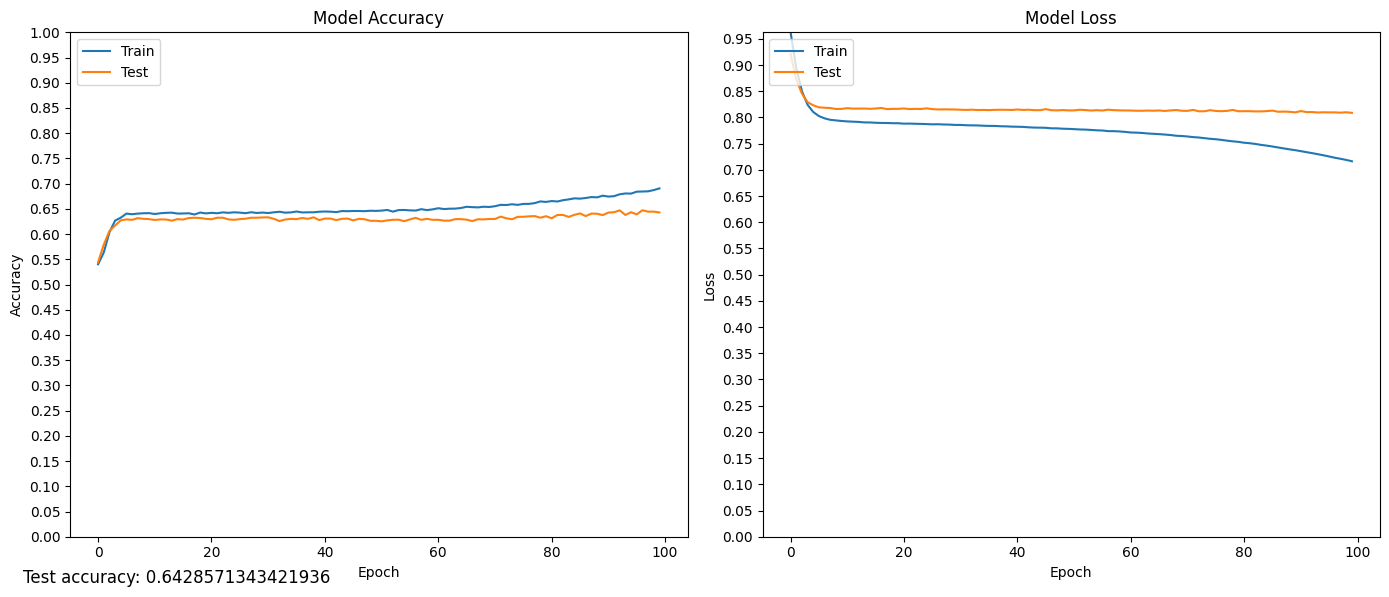

In [125]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks([i / 20 for i in range(21)])  # 0, 0.1, 0.2, ..., 1.0

plt.ylim(0, 1)  # Adjust the y-axis limit to provide space at the top

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks([i / 20 for i in range(21)])  # 0, 0.1, 0.2, ..., 1.0

plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))  # Adjust y-axis limit dynamically

# Put test accuracy as a label on the plot
plt.figtext(0.02, 0.02, "Test accuracy: " + str(test_accuracy), fontsize=12, ha='left')  # Adjust the position of text

# Adjust layout to remove white space
plt.tight_layout()
plt.show()


Epoch 1/100
455/455 [==============================] - 10s 15ms/step - loss: 0.9252 - accuracy: 0.5607 - val_loss: 0.8520 - val_accuracy: 0.6019
Epoch 2/100
455/455 [==============================] - 6s 13ms/step - loss: 0.8520 - accuracy: 0.6004 - val_loss: 0.8252 - val_accuracy: 0.6187
Epoch 3/100
455/455 [==============================] - 6s 13ms/step - loss: 0.8331 - accuracy: 0.6100 - val_loss: 0.8151 - val_accuracy: 0.6266
Epoch 4/100
455/455 [==============================] - 6s 13ms/step - loss: 0.8191 - accuracy: 0.6259 - val_loss: 0.7994 - val_accuracy: 0.6382
Epoch 5/100
455/455 [==============================] - 6s 13ms/step - loss: 0.8048 - accuracy: 0.6302 - val_loss: 0.7885 - val_accuracy: 0.6431
Epoch 6/100
455/455 [==============================] - 6s 13ms/step - loss: 0.7965 - accuracy: 0.6369 - val_loss: 0.7835 - val_accuracy: 0.6409
Epoch 7/100
455/455 [==============================] - 6s 13ms/step - loss: 0.7871 - accuracy: 0.6441 - val_loss: 0.7749 - val_accuracy

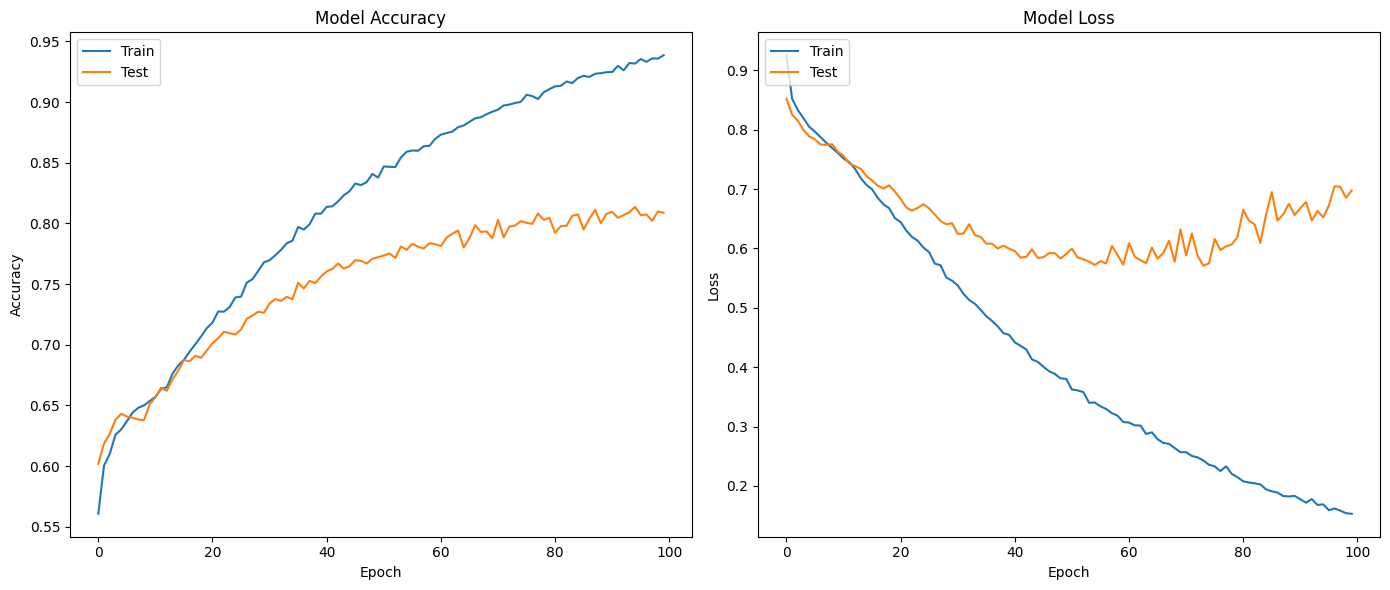

In [179]:
def build_model(window_size):
    learning_rate = 0.0005
    optim = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        # First LSTM layer with the correct input shape
        LSTM(64, return_sequences=True, input_shape=(window_size, 21)),  # 21 is the number of one-hot encoded features
        Dropout(0.5),
        # Second LSTM layer, no need to specify input_shape here
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        # Output layer
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding at the start and end
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    
    # Create windows without flattening them
    windows = np.array([padded_seqs[i:i + window_size] for i in range(len(encoded_seqs))])
    return windows

# Assuming the rest of the data loading and encoding code is correct and remains unchanged

# Adjust the window size here if needed
window_size = 13
windowed_input = create_sliding_windows(np.array(eseq), window_size=window_size)

# Assuming the rest of the training code remains unchanged
model = build_model(window_size)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# Continue with model evaluation and plotting as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

# Plotting the accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()